In [12]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import sys
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=2.5, rc={
    "lines.linewidth": 2,
    "lines.markersize":20,
    "ps.useafm": True,
    "font.sans-serif": ["Helvetica"],
    "pdf.use14corefonts" : True,
    "text.usetex": True,
    })

note2id = {'Nursing/other': 900001, 'Physician': 900002, 'Nutrition': 900003, 'General': 900004, 'Nursing': 900005, 'Respiratory ': 900006,'Rehab Services': 900007, 'Social Work': 900008, 'Echo': 900010,'ECG': 900011,'Case Management ': 900012,'Pharmacy': 900013,'Consult': 900014, 'Radiology': 900015, 'Discharge summary': 900016}

DATA_DIR = "/data/test_mimic_output/"
BASE_DIR = "/home/joe/value-of-medical-notes/"

In [27]:
import functools

def _get_pairwise_results(task, note, period, segment):
    feature_used="notes"
    model_name = task+'_'+note +'_'+ period + '.csv'
    if feature_used == "all":
        model_name = "feature_text_" + model_name
    elif feature_used == "all_but_notes":
        model_name = "feature_" + model_name
    else:
        model_name = "text_" + model_name
    if segment:
        model_name = str(segment) + "_" + model_name
    results = pd.read_csv(f'{BASE_DIR}/models/logistic_regression/compare_notes_pairwise/{model_name}')
    return results
def get_pairwise_results(task, note, period):
    results = []
    for i in range(10):
        res = _get_pairwise_results(task, note, period, str(i))
        results.append(res)
    sum_result = functools.reduce(lambda a,b:a+b, results)
    mean_result = sum_result/10
    return mean_result

def plot_save_pairwise_heatmap(task, note, vmin=None, vmax=None):
    period = "24" if task == "mortality" else "retro" 
    
    if task == "readmission":
        notes = ["Nursing/other", "Radiology", "ECG", "Physician","Discharge summary"] # no ECG this time
    else:
        notes = ["Nursing/other", "Radiology", "ECG", "Physician"]
    output = np.zeros((len(notes), len(notes)))
    result = get_pairwise_results(task, note, period)
    for i in range(len(notes)):
        for j in range(i, len(notes)):
            note_1 = notes[i]
            note_2 = notes[j]
            if note_1 == note_2: continue

            for feature_used in ['notes']: # , "all"
                note_id_1 = str(note2id[note_1])
                note_id_2 = str(note2id[note_2])
                pr_note1 = result[note_id_1+"_"+note_id_2].iloc[0]
                pr_note2 = result[note_id_1+"_"+note_id_2].iloc[1]
                #print(tmp_test)
                for model in ['logistic_regression']: #, 'GRU-D', 'DeepAverageNetwork'
                    output[i,j] = pr_note1 - pr_note2
                    output[j,i] = pr_note2 - pr_note1


    #f, axes = plt.subplots(len(output.keys()), figsize=(7, 7), sharex=True)
    #num_col = len(periods)*2*2
    i=0
    note_tick = [n[0] for n in notes]
    model_name = {'logistic_regression':"LR", 'DeepAverageNetwork':"DAN", 'GRU-D':"GRU-D"}

    fig, ax = plt.subplots()
    title = f"LR\\\\notes\\_{period}\\_PR-AUC"
    #ax.set_title(title, loc='center')
    ax = sns.heatmap(output, ax=ax,\
                                  center=0, cmap="RdBu",vmin=vmin, vmax=vmax, xticklabels=note_tick, yticklabels=note_tick, square=True)

    file_name = f"pairwise_{task}_LR_notes_{period}_PR-AUC.pdf"
    plt.tight_layout()
    if not os.path.exists(os.path.join('figure/',task)):
        os.mkdir(os.path.join('figure/',task))
    fig.savefig(os.path.join('figure/',task,file_name))


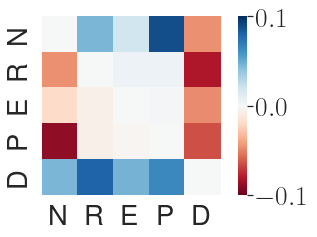

In [29]:
plot_save_pairwise_heatmap('readmission', 'all',  vmin=-0.1, vmax=0.1)

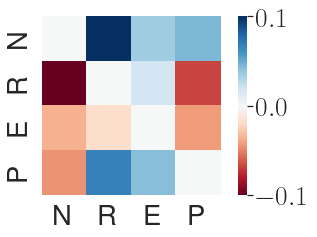

In [28]:
plot_save_pairwise_heatmap('mortality', 'all_but_discharge',  vmin=-0.1, vmax=0.1)